In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [3]:
I2 = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Phase diagram

In [5]:
# Order parameter calculation
def order_parameter(x):
    return x ** 2

# Solution for steady-state variables x, y, z
def solution_set(Delta, J, L, gamma_d, gamma_r):
    # Common term in x and y
    sqrt_term = np.sqrt(gamma_r * (gamma_r + gamma_d) / (8 * J * L * Delta))
    
    # Correction term for x and y
    correction_term = 1 - (16 * Delta**2 + (gamma_r + gamma_d)**2) / (16 * J * L * Delta)
    
    # x coordinate calculation (positive and negative solutions)
    x_pos = (4 * Delta / (gamma_r + gamma_d)) * sqrt_term * np.sqrt(correction_term)
    x_neg = -x_pos

    # y coordinate calculation (positive and negative solutions)
    y_pos = sqrt_term * np.sqrt(correction_term)
    y_neg = -y_pos

    # z coordinate calculation
    z = (-16 * Delta**2 - (gamma_r + gamma_d)**2) / (16 * J * L * Delta)

    # Returning two sets of solutions
    return [(x_pos, y_pos, z), (x_neg, y_neg, z)]

# # Phase diagram of \Delta and γ = γ_{d} = γ_{r}
# Delta = np.linspace(0.01, 1.5, 500)  # Avoid zero to prevent division error
# gamma = np.linspace(0.01, 1.6, 500)  # Same here for stability

# L = 100
# J = 1 / (L - 1)

# # Create a meshgrid for Delta and gamma
# Delta, gamma = np.meshgrid(Delta, gamma)

# # Calculate the order parameter for each combination of Delta and gamma
# order_param = np.zeros(Delta.shape)
# for i in range(Delta.shape[0]):
#     for j in range(Delta.shape[1]):
#         solutions = solution_set(Delta[i, j], J, L, gamma[i, j], gamma[i, j])
#         order_param[i, j] = max(order_parameter(solutions[0][0]), order_parameter(solutions[1][0]))

# contour_values = gamma - 2 * np.sqrt(Delta * (1 - Delta))

In [6]:
# plt.figure(figsize=(8, 6))

# colors = [
#      '#2E1F5E', 
#      '#343EA2', 
#      '#4B75D6', 
#      '#62A6F3', 
#      '#7BCEF8', 
#      '#97E6C3', 
#      '#BCE17F', 
#      '#E2DC55', 
#      '#FFD700'
# ]
# custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# contour = plt.contourf(Delta, gamma, order_param, levels=100, cmap=custom_cmap)
# cbar = plt.colorbar(contour, label='$M^{MF} = x^{2}$', pad=0.05, format='%.2f')
# cbar.ax.set_ylabel('$M^{MF} = x^{2}$', labelpad=20)

# plt.contour(
#      Delta, gamma, contour_values, 
#      levels=[0], colors='red', linestyles='dashed', linewidths=2
# )
# # Add a separate proxy line for the legend
# plt.plot([], [], color='red', linestyle='dashed', linewidth=2, label='Phase boundary')
# plt.legend()

# plt.xlabel(r'$\Delta$', labelpad=10)
# plt.ylabel(r'$\gamma$', labelpad=10)
# plt.title(r'Order parameter in the mean field limit', pad=20)
# plt.tight_layout()
# # plt.savefig('phase_diagram.png', dpi=600, bbox_inches='tight')
# plt.show()

# Numerical solution to the optical Bloch equations

Steady state solutions:
Solution 1:
x: 0.4770, y: 0.1431, z: -0.5445
Solution 2:
x: -0.4770, y: -0.1431, z: -0.5445
Initial conditions:
x0: 1.0000
y0: 0.0000
z0: 0.0000
Final values:
x: 0.4761
y: 0.1430
z: -0.5453


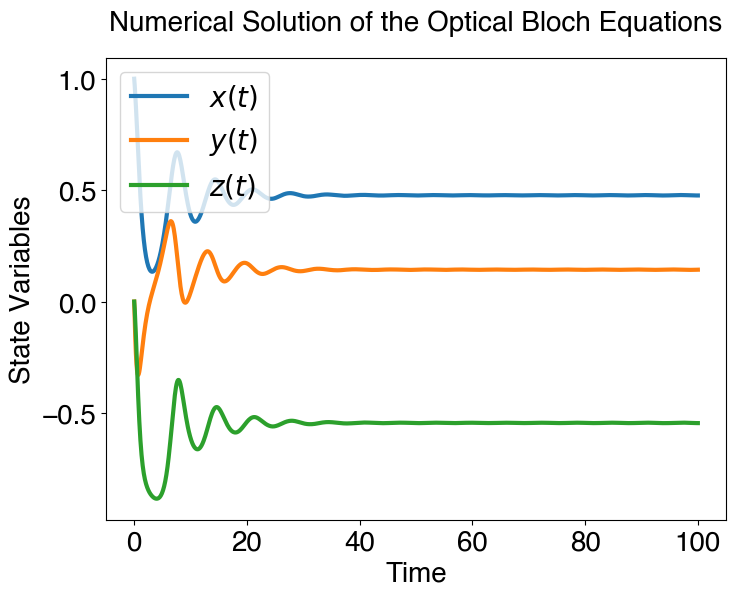

In [7]:
# Set parameters
L = 1000
gamma_r = 0.3   # Relaxation rate
gamma_d = 0.3   # Dephasing rate
Delta   = 0.5   # Transverse field
J       = 1 / ( L - 1)

# Define the differential equations
def bloch_equations(t, vars, gamma_r, gamma_d, Delta, J, L):
    x, y, z = vars
    dxdt = - (gamma_r / 2 + gamma_d / 2) * x + 2 * Delta * y
    dydt = -2 * J * L * z * x - 2 * Delta * x - (gamma_r / 2 + gamma_d / 2) * y
    dzdt = 2 * J * L * y * x - gamma_r * (1 + z)
    return [dxdt, dydt, dzdt]

print('Steady state solutions:')
solutions = solution_set(Delta, J, L, gamma_r, gamma_d)
for i, sol in enumerate(solutions):
    print(f"Solution {i+1}:")
    print(f"x: {sol[0]:.4f}, y: {sol[1]:.4f}, z: {sol[2]:.4f}")

# Initial density matrix
initial_qubit_state = (1/np.sqrt(2)) * np.array([1, 1])
rho_i = np.outer(initial_qubit_state, initial_qubit_state.conj())  # Density matrix
rho_i /= np.trace(rho_i)  # Normalize the density matrix

# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Initial conditions
x0, y0, z0 = np.real(np.trace(rho_i @ sigma_x)), np.real(np.trace(rho_i @ sigma_y)), np.real(np.trace(rho_i @ sigma_z))

print('Initial conditions:')
print(f"x0: {x0:.4f}")
print(f"y0: {y0:.4f}")
print(f"z0: {z0:.4f}")

# Time range for integration
t_span = (0, 100)  # Time interval
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Solve the system using solve_ivp
sol = solve_ivp(
    bloch_equations, 
    t_span, 
    [x0, y0, z0], 
    args=(gamma_r, gamma_d, Delta, J, L), 
    t_eval=t_eval, 
    method='RK45'
)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label=r'$x(t)$', linewidth=3)
plt.plot(sol.t, sol.y[1], label=r'$y(t)$', linewidth=3)
plt.plot(sol.t, sol.y[2], label=r'$z(t)$', linewidth=3)

# Get final values
final_x = sol.y[0][-1]
final_y = sol.y[1][-1]
final_z = sol.y[2][-1]

print("Final values:")
print(f"x: {final_x:.4f}")
print(f"y: {final_y:.4f}")
print(f"z: {final_z:.4f}")

plt.title("Numerical Solution of the Optical Bloch Equations")
plt.xlabel("Time")
plt.ylabel("State Variables")
plt.legend()
plt.show()

# Cost function and optical Bloch equation

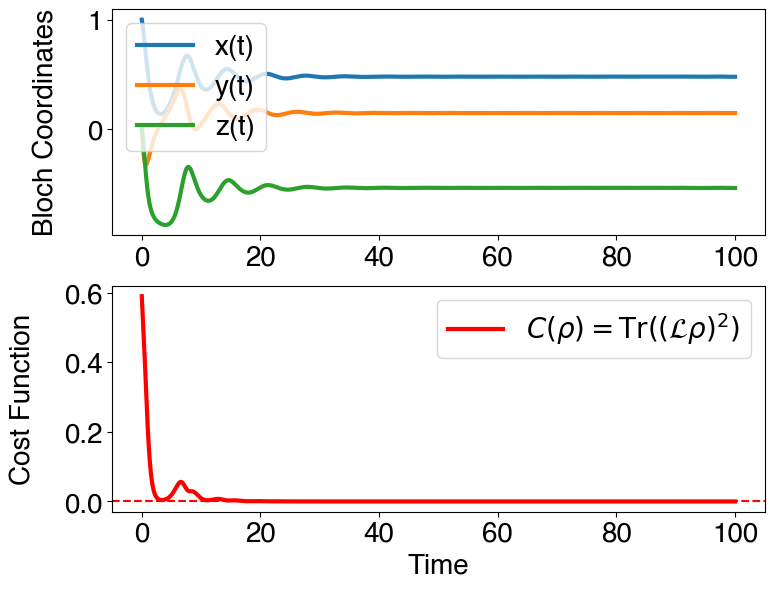

Steady state solutions:
Solution 1:
x: 0.4770, y: 0.1431, z: -0.5445
Solution 2:
x: -0.4770, y: -0.1431, z: -0.5445
Final Bloch coords:
 x = 0.4761,   y = 0.1430,   z = -0.5453
Final cost function: 3.307984e-07
Cost function: 3.307984168347632e-07


In [8]:
# Pauli matrices
sigma_x = np.array([[0, 1],[1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j],[1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0],[0, -1]], dtype=complex)
Id2     = np.eye(2, dtype=complex)

def density_matrix_from_bloch(x, y, z):
    "Single qubit density matrix as a function of x; y and z"
    return 0.5 * ( Id2 + x * sigma_x + y * sigma_y + z * sigma_z )

def build_mean_field_hamiltonian(x_mean):
    "Hamiltonian in the mean field limit"
    return J * L * x_mean * sigma_x - Delta * sigma_z

def jump_operators(gamma_r, gamma_d):
    "Lindblad operator acting on a single qubit"
    L1 = np.sqrt(gamma_r) * (sigma_x - 1j*sigma_y)/2
    L2 = np.sqrt(gamma_d) * (Id2 + sigma_z)/2
    return L1, L2

def lindbladian(rho, x_mean):
    "Construct the Lindblad equation"
    # Build single-qubit mean-field Hamiltonian:
    H = build_mean_field_hamiltonian(x_mean)
    L1, L2 = jump_operators(gamma_r, gamma_d)

    # Commutator part: -i [H, rho]
    comm  = -1j * ( H @ rho - rho @ H )

    # Dissipators:
    dis1  = L1@rho@L1.conj().T - 0.5*(L1.conj().T@L1@rho + rho@L1.conj().T@L1)
    dis2  = L2@rho@L2.conj().T - 0.5*(L2.conj().T@L2@rho + rho@L2.conj().T@L2)

    return comm + dis1 + dis2

def cost_function(rho, x_mean):
    """
    Cost = Tr[  (L rho)^\dagger (L rho ) ], where L is the Lindbladian superoperator.
    Here, L_rho is the matrix returned by lindbladian(rho, x_mean).
    """
    L_rho = lindbladian(rho, x_mean)
    # Frobenius norm squared of L_rho:
    return np.real(np.trace( L_rho.conj().T @ L_rho ))

t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# Integrate Bloch Equations
sol = solve_ivp(
    bloch_equations, t_span, [x0, y0, z0],
    args=(gamma_r, gamma_d, Delta, J, L),
    t_eval=t_eval, dense_output=False
)

# Evaluate cost function at each time step
cost_vals = []
for i in range(len(sol.t)):
    # Current Bloch coords
    x_t, y_t, z_t = sol.y[:,i]  
    # Reconstruct single-qubit rho(t)
    rho_t = density_matrix_from_bloch(x_t, y_t, z_t)
    # We pass x_t as the "mean-field" x_mean to build the Hamiltonian
    cost_vals.append( cost_function(rho_t, x_t) )

# Plot the time evolution
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(sol.t, sol.y[0], label='x(t)', lw=3)
plt.plot(sol.t, sol.y[1], label='y(t)', lw=3)
plt.plot(sol.t, sol.y[2], label='z(t)', lw=3)
plt.ylabel("Bloch Coordinates", labelpad = 20)
plt.legend()

plt.subplot(2,1,2)
plt.plot(sol.t, cost_vals, color='red', lw=3, label=r'$C(\rho) = \mathrm{Tr}( (\mathcal{L} \rho)^{2} )$')
plt.axhline( y = 0 , linestyle = '--', color = "red")
plt.xlabel("Time")
plt.ylabel("Cost Function", labelpad = 20)
plt.legend()
plt.tight_layout()
# plt.savefig('cost_function_as_function_of_time_PM.pdf', dpi = 600, bbox_inches='tight')
plt.show()

print('Steady state solutions:')
solutions = solution_set(Delta, J, L, gamma_r, gamma_d)
for i, exact_sol in enumerate(solutions):
    print(f"Solution {i+1}:")
    print(f"x: {exact_sol[0]:.4f}, y: {exact_sol[1]:.4f}, z: {exact_sol[2]:.4f}")

print("Final Bloch coords:")
print(f" x = {sol.y[0][-1]:.4f},   y = {sol.y[1][-1]:.4f},   z = {sol.y[2][-1]:.4f}")
print(f"Final cost function: {cost_vals[-1]:.6e}")

print('Cost function:', cost_vals[-1])

# Variational quantum circuit

In [5]:
# Variational ansatz.
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

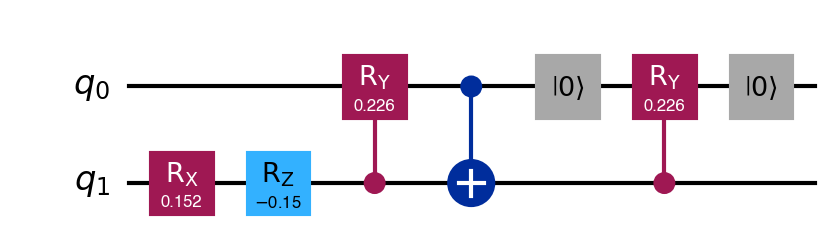

In [9]:
def variationl_circuit(Delta, L, J, x, dt, num_layer, num_qubit):

     theta_2 = J * L * x * dt
     theta_3 = - Delta * dt
     theta_r = np.arcsin(np.sqrt(gamma * dt))
     theta_d = np.arcsin(np.sqrt(gamma * dt))

     qc = QuantumCircuit(num_qubit)

     for layer in range(num_layer):
          for qubit in range(1,num_qubit):
               qc.rx(theta_2,qubit)
               qc.rz(theta_3,qubit)

               qc.cry(theta_r, qubit, 0)
               qc.cx(0, qubit)

               qc.reset(0)

               qc.cry(theta_d, qubit, 0)

               qc.reset(0)  

     return qc

Delta = 1.5
L = 100
J = 1 / ( L - 1 )
gamma = 0.5
dt = 0.1
x = 1.5
variationl_circuit(Delta, L, J, x, dt, num_layer=1, num_qubit=2).draw('mpl', scale = 1.5)#.savefig('variational_circuit.pdf', dpi=600, bbox_inches='tight')

In [ ]:
def compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer):
    """
    Compute gradients using the parameter-shift rule.

    Parameters:
        angles_lst (list): Current angles for the variational circuit.
        number_of_layers (int): Number of layers in the circuit.
        number_of_parameters_per_layer (int): Number of parameters per layer.

    Returns:
        list: Gradients for each parameter.
    """
    gradients = [[0.0] * number_of_parameters_per_layer for _ in range(number_of_layers)]
    for l in range(number_of_layers):
        for p in range(number_of_parameters_per_layer):
            # Create shifted angle sets
            angles_plus = copy.deepcopy(angles_lst)
            angles_minus = copy.deepcopy(angles_lst)
            angles_plus[l][p] += np.pi / 2
            angles_minus[l][p] -= np.pi / 2

            # Compute the cost for shifted parameters
            vqa_circuit_plus = variational_circuit(angles_plus, number_of_layers)
            vqa_circuit_minus = variational_circuit(angles_minus, number_of_layers)
            rho_plus = return_density_matrix(vqa_circuit_plus)
            rho_minus = return_density_matrix(vqa_circuit_minus)

            cost_plus = cost_function(rho_plus)
            cost_minus = cost_function(rho_minus)

            # Compute the gradient
            gradients[l][p] = (cost_plus - cost_minus) / 2

    return gradients

def gradient_descent_optimizer(angles_lst, number_of_layers, number_of_parameters_per_layer, 
                       learning_rate, cost_function,
                       max_iterations=100, 
                       tolerance_for_convergence=1e-4):
    """
    Gradient Descent optimizer for variational quantum algorithms.
    """
    rho_lst = []
    cost_function_values_lst = []
    best_angles_lst = copy.deepcopy(angles_lst)
    best_cost = float('inf')

    for iteration in range(max_iterations):
       # Calculate current learning rate with decay
       current_learning_rate = learning_rate * (1.0 / (1.0 + 0.1 * iteration))

       # Generate variational circuit and compute cost
       vqa_circuit = variational_circuit(angles_lst, number_of_layers)
       rho = return_density_matrix(vqa_circuit)
       rho_lst.append(rho)
       cost_value = cost_function(rho)
       cost_function_values_lst.append(cost_value)

       print(f"Iteration {iteration}: Cost = {cost_value:.6f}, angles = {angles_lst}")

       # Update the best cost and parameters
       if cost_value < best_cost:
          best_cost = cost_value
          best_angles_lst = copy.deepcopy(angles_lst)

       # Check for convergence
       if iteration > 0 and abs(cost_function_values_lst[-1] - cost_function_values_lst[-2]) < tolerance_for_convergence:
          print("Converged.")
          break

       # Compute gradients using parameter-shift rule
       gradients = compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer)

       # Update parameters using gradient descent with decaying learning rate
       for l in range(number_of_layers):
          for p in range(number_of_parameters_per_layer):
             angles_lst[l][p] -= current_learning_rate * gradients[l][p]

    return {
       'rho_lst': rho_lst,
       "optimized_angles": best_angles_lst,
       "best_cost": best_cost,
       "cost_function_values": cost_function_values_lst,
    }

number_of_layers = 1
initial_learning_rate = 0.01
maximum_iterations = 200


In [ ]:
def FM_order(rho):
    # Initialize the spin correlation matrix
    spin_matrix = csr_matrix((rho.shape[0], rho.shape[0]), dtype=complex)
    
    for i in range(L):
        for j in range(L):
            # Create sigma_x operator for qubit i
            sigma_x_ij = [I2] * L
            sigma_x_ij[i] = sigma_x            
            # Create sigma_x operator for qubit j
            sigma_x_ij[j] = sigma_x
            sigma_x_ij_op = sigma_x_ij[0]
            for op in sigma_x_ij[1:]:
                sigma_x_ij_op = kron(sigma_x_ij_op, op)
                
            spin_matrix += sigma_x_ij_op

    # Calculate M_F using the trace formula
    mf = np.trace(spin_matrix @ rho) / L**2
    return mf.real  # Return the real part (expectation values are real)